In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from hydra import initialize, compose
import astropy.cosmology as astropy_cosmo
from pyHalo.preset_models import CDM
from pprint import pprint

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

# enable use of local modules
repo_dir  = config.machine.repo_dir
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

from mejiro.lenses.lens import Lens
from mejiro.plots import plot
from mejiro.helpers import pyhalo, pandeia_input

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

# Set up a strong lens in `lenstronomy`

In [2]:
band = 'f106'
z_lens = 0.5
z_source = 2.

kwargs_lens = [{'center_x': 0.1,
  'center_y': -0.1,
  'e1': 0.01,
  'e2': 0.02,
  'gamma': 2,
  'theta_E': 0.8},
 {'dec_0': 0,
  'gamma1': -0.02,
  'gamma2': 0.005,
  'ra_0': 0},
 {'dec_0': 0, 'kappa': -0.036, 'ra_0': 0}]

kwargs_lens_light = [{'R_sersic': 0.38,
  'center_x': 0.1,
  'center_y': -0.1,
  'e1': 0.03,
  'e2': 0.05,
  'magnitude': 19.75,
  'n_sersic': 1.0}]

kwargs_source = [{'R_sersic': 0.16,
  'center_x': -0.02,
  'center_y': 0.04,
  'e1': -0.39,
  'e2': -0.12,
  'magnitude': 23.24,
  'n_sersic': 1.0}]

kwargs_params = {
    'kwargs_lens': kwargs_lens,
    'kwargs_lens_light': kwargs_lens_light,
    'kwargs_source': kwargs_source
}

kwargs_model = {
    'cosmo': astropy_cosmo.default_cosmology.get(),
 'lens_light_model_list': ['SERSIC_ELLIPSE'],
 'lens_model_list': ['EPL', 'SHEAR', 'CONVERGENCE'],
 'lens_redshift_list': [z_lens] * 3,
 'source_light_model_list': ['SERSIC_ELLIPSE'],
 'source_redshift_list': [z_source],
 'z_source': z_source,
 'z_source_convention': 5.}

In [3]:
lens = Lens(kwargs_model, kwargs_params, band, uid=0)

# Add subhalos with `pyhalo`

First, generate a population of CDM subhalos

In [4]:
realizationCDM = CDM(z_lens, z_source, cone_opening_angle_arcsec=6.,
                         LOS_normalization=0., log_mlow=6., log_mhigh=10.)

`pyhalo` has nice plotting routines - [from `pyhalo`'s "Basic usage" Jupyter notebook](https://github.com/dangilman/pyHalo/blob/master/example_notebooks/basic_usage.ipynb):

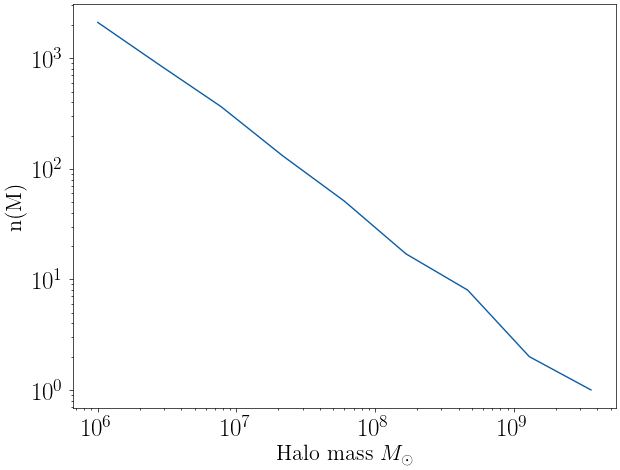

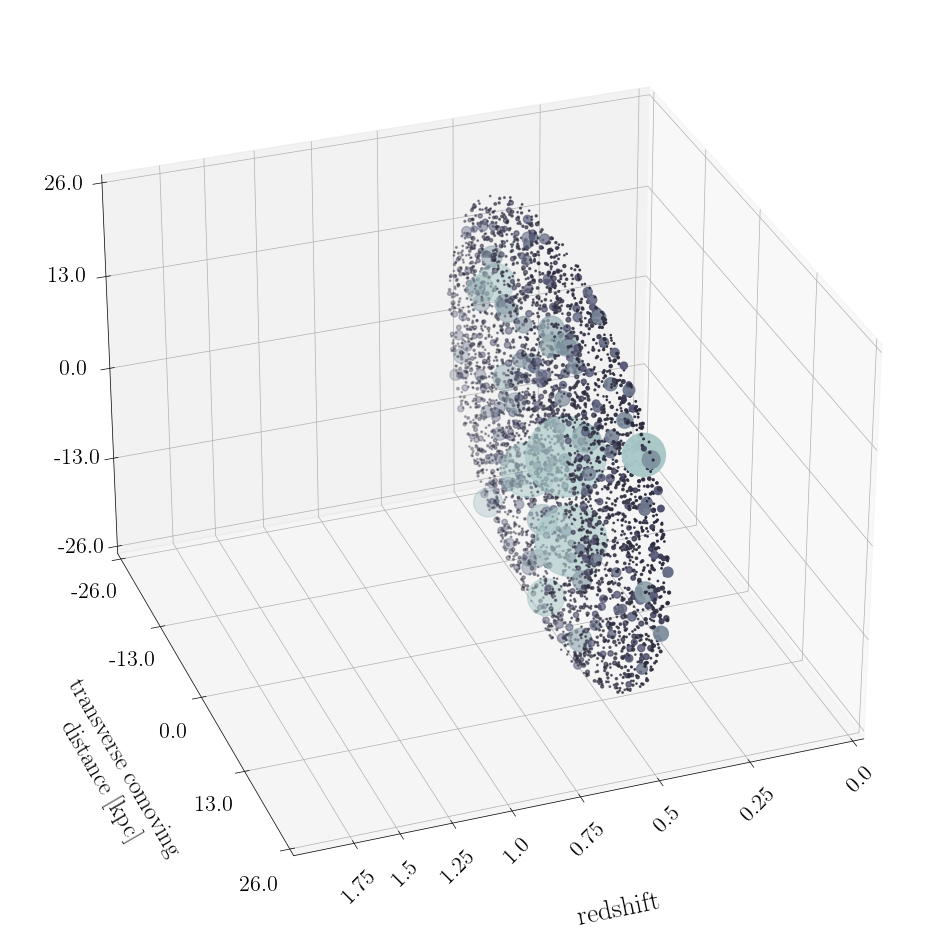

In [5]:
cdm_halo_masses = [halo.mass for halo in realizationCDM.halos]
N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))

fig = plt.figure(1)
ax = plt.subplot(111)
ax.loglog(m[0:-1], N)
ax.set_xlabel('Halo mass '+r'$M_{\odot}$', fontsize=16)
ax.set_ylabel('n(M)', fontsize=16)

fig = plt.figure(figsize=(14, 12))
ax = plt.subplot(111, projection='3d')
realizationCDM.plot(ax)

Add this to the strong lens

In [6]:
lens.add_subhalos(*pyhalo.realization_to_lensing_quantities(realizationCDM))

# Produce the synthetic image with `lenstronomy`

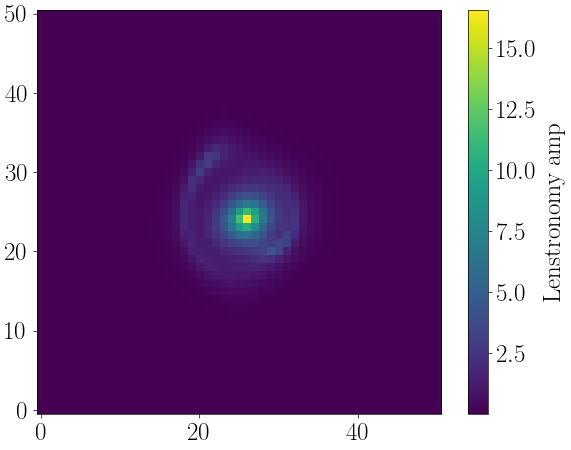

In [7]:
model = lens.get_array(num_pix=51, side=5.61)

plot.plot(model, colorbar=True, colorbar_label='Lenstronomy amp')

# Run this synthetic lens through Pandeia

Generate the input .json file for the Pandeia engine

In [8]:
calc, num_point_sources = pandeia_input.build_pandeia_calc(model, lens, background=True, band='f106', max_scene_size=5, num_samples=10000,
                       suppress_output=False)

RA: 36.69264407023392, DEC: -32.418407953398344


100%|██████████| 580/580 [00:03<00:00, 164.63it/s]

Point source conversion complete: placed 580 point sources
Estimated calculation time: 0:00:46


In [9]:
pprint(calc['configuration']['instrument'])

{'aperture': 'imaging',
 'disperser': None,
 'filter': 'f106',
 'instrument': 'wfi',
 'mode': 'imaging'}


In [10]:
pprint(calc['configuration']['detector'])

{'ma_table_name': 'hlwas_imaging',
 'nexp': 1,
 'ngroup': 10,
 'nint': 1,
 'readout_pattern': 'deep2',
 'subarray': 'imaging'}


In [11]:
pprint(calc['calculation'])

{'effects': {'saturation': True},
 'noise': {'crs': True,
           'dark': True,
           'excess': False,
           'ffnoise': True,
           'readnoise': True,
           'scatter': False}}


Generate the image

In [12]:
image, execution_time = pandeia_input.get_pandeia_image(calc, suppress_output=False)

Performing Pandeia calculation...
Pandeia calculation complete in 0:00:35


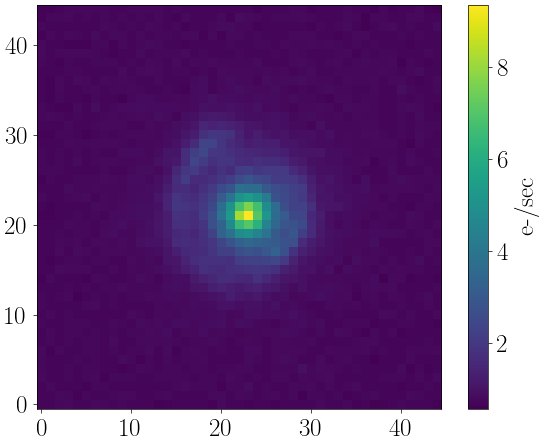

In [13]:
plot.plot(image, colorbar=True, colorbar_label='e-/sec')